In [2]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset, KnownEncoderDiffusionDataset, GRUDiffusionDataset
from data.hmm import CompositionalHMMDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat, rearrange
from models.encoder import KnownEncoder
from models.decoder import TransformerDecoder
from tqdm import tqdm
from tasks.metalearn import MetaLearningTask
import torch.nn as nn
import pandas as pd
import seaborn as sns

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [3]:
task = MetaLearningTask.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/39sfv9fz/last.ckpt", strict=False
)
task.setup()
#4n62mk47

In [4]:
pp_dict = task.evaluate_pp(samples=100, n_steps=200)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
100it [00:28,  3.45it/s]


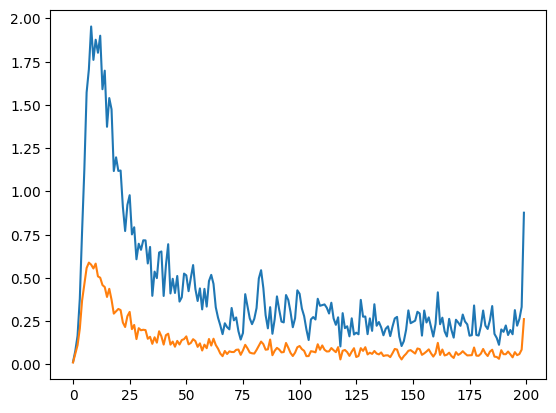

In [6]:
plt.plot(pp_dict['BackwardKL'].mean(0))
plt.plot(pp_dict['ForwardKL'].mean(0))

In [46]:
task = DSMDiffusion.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/22zbjlpa/last.ckpt", strict=False
)
task.cuda();

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [47]:
dataset = task.full_data
dataset: KnownEncoderDiffusionDataset

In [48]:
N_SEQS = 50
N_SAMPLES = 10
C_LEN = 8
MAX_LEN = 30

# Explicit latent posterior

In [ ]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset[433].values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [ ]:
cond_ignore_mask = torch.BoolTensor([False] * C_LEN + [True] * (cond_input_ids.shape[-1] - C_LEN)).cuda()

In [ ]:
cond_ignore_mask = repeat(
    cond_ignore_mask,
    "l -> b l",
    b=N_SAMPLES,
)

In [ ]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50

In [ ]:
z_t = task.sample(
    N_SAMPLES,
    cond=repeat(cond_tokens, '1 l d -> b l d', b=N_SAMPLES),
    cond_input_ids=repeat(cond_input_ids, '1 l -> b l', b=N_SAMPLES),
    cond_mask=torch.logical_not(cond_ignore_mask),
    cls_free_guidance=1.0,
)
if task.cfg.normalize_latent:
    z_t = task.unnormalize_latent(z_t)

In [ ]:
true_envs_encodings = task.full_data.known_encoder(
    true_latents=j2t(task.full_data.base_task.full_data.index_to_latent).int().cuda()
)

In [ ]:
dist = torch.cdist(true_envs_encodings[None,:,0], z_t[None,:,0])[0].T**2
empirical_dist = torch.nn.functional.softmax(-dist*2,dim=1).mean(0)
empirical_dist = t2j(empirical_dist)

In [ ]:
if False:
    decoded_task_latent = [
        torch.Tensor(
            [
                (latent_embds.weight @ sampled_latent.T).argmax()
                for latent_embds in task.full_data.known_encoder.latent_embedding
            ]
        )
        for sampled_latent in z_t
    ]
    decoded_task_latent = torch.stack(decoded_task_latent, 0)
    decoded_task_id = jnp.stack(
        [
            (
                task.full_data.base_task.full_data.index_to_latent
                == t2j(decoded_task_latent[i])
            )
            .all(-1)
            .argmax()
            for i in range(len(decoded_task_latent))
        ]
    )
    # Compuate empirical distribution
    empirical_dist = jnp.bincount(
        decoded_task_id, minlength=len(task.full_data)
    )
    empirical_dist = empirical_dist / empirical_dist.sum()

In [ ]:
oracle = task.full_data.base_task.full_data.bayesian_oracle(
    jnp.arange(len(task.full_data.base_task.full_data)),
    t2j(cond_input_ids[0]),
)

In [ ]:
oracle_dist = oracle["log_alpha_post"][C_LEN]
oracle_dist = jnp.exp(oracle_dist)
empirical_dist = jax.device_put(empirical_dist, oracle_dist.device)

In [ ]:
# Forward KL(oracle, empirical) (with small epsilon)
empirical_dist_ = empirical_dist + 1e-8
empirical_dist_ = empirical_dist_ / empirical_dist_.sum()
f_kl = rel_entr(oracle_dist, empirical_dist_).sum()

#  Backward KL(empirical, oracle) (with small epsilon)
oracle_ = oracle_dist + 1e-8
oracle_ = oracle_ / oracle_.sum()
b_kl = rel_entr(empirical_dist, oracle_).sum()

In [ ]:
print(f_kl, b_kl)

0.13038512 0.68563837


In [ ]:
print('Oracle')
for id in oracle_dist.round(2).nonzero()[0]:
    print(f'HMM #{id}, {task.full_data.base_task.full_data.index_to_latent[id.item()]} : {oracle_dist[id.item()]}')
print('Model')
for id in empirical_dist.round(2).nonzero()[0]:
    print(f'HMM {task.full_data.base_task.full_data.index_to_latent[id.item()]}, #{id}  : {empirical_dist[id.item()]}')

Oracle
HMM #49, [0 0 0 0 0 0 1 0 0 0 0 1] : 0.5333231091499329
HMM #433, [0 0 0 1 0 0 1 0 0 0 0 1] : 0.4665241539478302
Model
HMM [0 0 0 0 0 0 1 0 0 0 0 1], #49  : 0.3213910162448883
HMM [0 0 0 0 0 1 1 0 0 0 0 1], #145  : 0.012019271962344646
HMM [0 0 0 1 0 0 1 0 0 0 0 1], #433  : 0.6293429136276245
HMM [0 0 0 1 0 1 1 0 0 0 0 1], #529  : 0.029368195682764053


# Posterior predictive : Implicit VS Explicit

In [49]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50

In [50]:
decoder = task.full_data.base_task.model.decoder.cuda()
decoder: TransformerDecoder

In [51]:
hmms = torch.randperm(len(dataset))[:N_SEQS]

raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = (
    dataset.__getitems__(hmms).values()
)

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [52]:
implicit_task = MetaLearningTask.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/f818u4jn/last.ckpt", strict=False
).cuda()

# Compute the implicit posterior predictive
implicit_pred = torch.nn.functional.softmax(
    implicit_task.model(cond_input_ids)[:, :, :50], dim=-1
).cpu().detach()

del implicit_task

# Compute the bayesian posterior predictive
oracle_pred = torch.zeros(N_SEQS, MAX_LEN, 50)
for j in range(len(hmms)):
    oracle_pred[j] = torch.Tensor(
        task.full_data.base_task.full_data.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(cond_input_ids)[j]
        )["post_pred"][1:].tolist()
    ).cpu()

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [53]:
decoder.requires_grad_(False);
task.requires_grad_(False);

In [63]:
explicit_pred = torch.zeros(N_SEQS, N_SAMPLES, MAX_LEN, 50)

for batch_id in torch.split(torch.arange(N_SEQS), 100):

    for i in tqdm(range(1, MAX_LEN + 1)):

        # Condition on the first <i> observations
        cond_ignore_mask = repeat(
            torch.BoolTensor([False] * i + [True] * (cond_input_ids.shape[-1] - i)),
            "l -> (b n) l",
            b=len(batch_id),
            n=N_SAMPLES,
        ).cuda()

        # Sample from the variational encoder
        z_t = task.sample(
            len(batch_id) * N_SAMPLES,
            cond=repeat(cond_tokens[batch_id], "b l d -> (b n) l d", n=N_SAMPLES) if cond_tokens != None else None,
            cond_input_ids=repeat(cond_input_ids[batch_id], "b l -> (b n) l", n=N_SAMPLES) if cond_input_ids != None else None,
            cond_mask=torch.logical_not(cond_ignore_mask),
            cls_free_guidance=2.0,
        )
        if task.cfg.normalize_latent:
            z_t = task.unnormalize_latent(z_t)

        # Use the decoder conditionned on the sampled latent
        explicit_pred_ = decoder(
            input_ids=repeat(
                cond_input_ids[batch_id], "b l -> (b n) l", b=len(batch_id), n=N_SAMPLES
            ),
            context_enc=z_t,
        )[:, i - 1, :50]
        # Perform monte-carlo estimate
        explicit_pred_ = rearrange(
            torch.nn.functional.softmax(explicit_pred_, dim=-1),
            "(b n) c -> b n c",
            b=len(batch_id),
            n=N_SAMPLES,
        )

        explicit_pred[batch_id, :, torch.full_like(batch_id, fill_value=i - 1)] = (
            explicit_pred_.cpu()
        )

100%|██████████| 30/30 [05:06<00:00, 10.22s/it]


In [55]:
# Compute the bayesian posterior predictive
oracle_pred_ = torch.zeros(N_SEQS, MAX_LEN, 50)
for j in range(len(hmms)):
    oracle_pred_[j] = torch.Tensor(
        task.full_data.base_task.full_data.bayesian_oracle(
            jnp.array([hmms[j].item()]),
            t2j(cond_input_ids)[j]
        )["post_pred"][1:].tolist()
    ).cpu()

In [60]:
def KLDiv(p,q):
    return torch.sum(p * (p.log() - q.log()), -1)

explicit_kl_b = KLDiv(explicit_pred.mean(1), oracle_pred)
implicit_kl_b = KLDiv(implicit_pred, oracle_pred)
explicit_kl_f = KLDiv(oracle_pred, explicit_pred.mean(1))
implicit_kl_f = KLDiv(oracle_pred, implicit_pred)
explicit_kl_b_sanity = KLDiv(explicit_pred.mean(1), oracle_pred_)
explicit_kl_f_sanity = KLDiv(oracle_pred_, explicit_pred.mean(1))

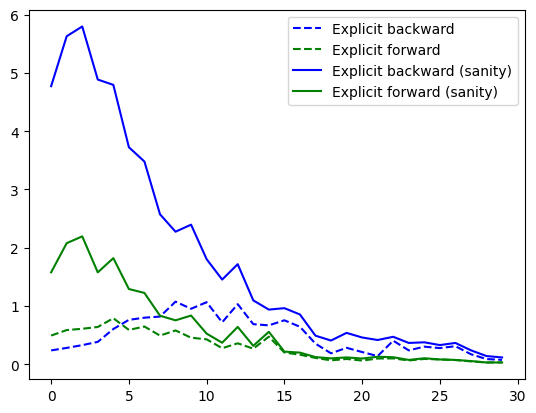

In [57]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.plot(explicit_kl_b_sanity.mean(0) , label='Explicit backward (sanity)', color='blue')
plt.plot(explicit_kl_f_sanity.mean(0) , label='Explicit forward (sanity)', color='green')
plt.legend()

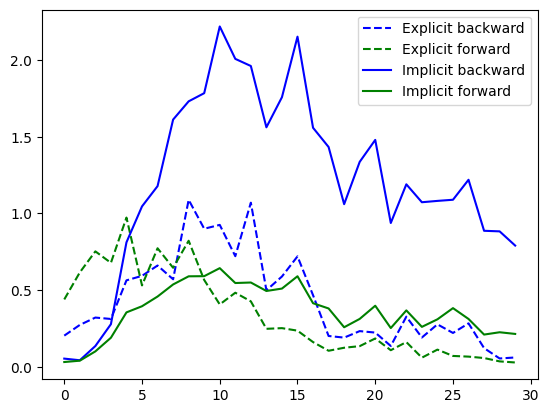

In [61]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.plot(implicit_kl_b.mean(0), label='Implicit backward', color='blue')
plt.plot(implicit_kl_f.mean(0), label='Implicit forward', color='green')
plt.legend()

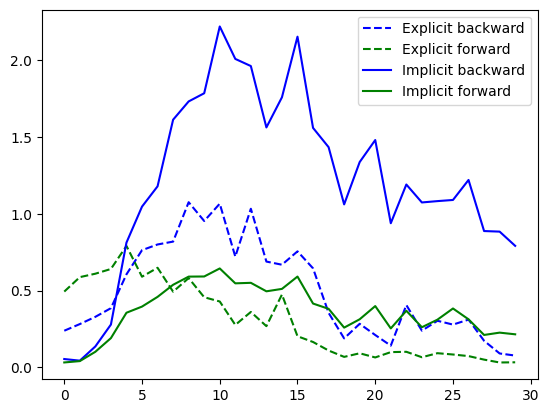

In [58]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.plot(implicit_kl_b.mean(0), label='Implicit backward', color='blue')
plt.plot(implicit_kl_f.mean(0), label='Implicit forward', color='green')
plt.legend()

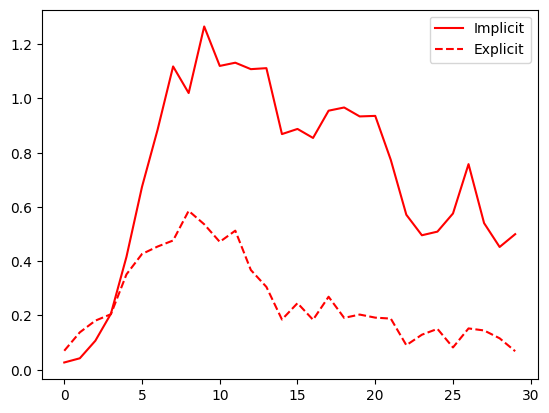

In [14]:
plt.plot((implicit_kl_f.mean(0) + implicit_kl_b.mean(0))/2, label='Implicit', color='red')
plt.plot((explicit_kl_f.mean(0) + explicit_kl_b.mean(0))/2, label='Explicit', color='red', linestyle='--')
plt.legend()

In [ ]:
plt.plot(oracle_pred[0,0], label='Oracle')
plt.plot(explicit_pred.mean(1)[0,0], label='Explicit')
plt.plot(implicit_pred[0,0], label='Implicit')
plt.legend()

In [ ]:
df1 = pd.DataFrame(torch.nn.functional.cross_entropy(
        torch.log(explicit_pred[:, :-1].transpose(1, 2)),
        sequences[:, 1:].cpu().long(),
        reduction="none",
    ))
df1['Model'] = "Explicit"
df2 = pd.DataFrame(torch.nn.functional.cross_entropy(
        torch.log(implicit_pred[:, :-1].transpose(1, 2).cpu().detach()),
        sequences[:, 1:].cpu().long(),
        reduction="none",
    ))
df2['Model'] = "Implicit"
df = pd.concat([df1, df2]).melt(id_vars=['Model'], var_name='Time', value_name='Cross-Entropy')

<Axes: xlabel='Time', ylabel='Cross-Entropy'>

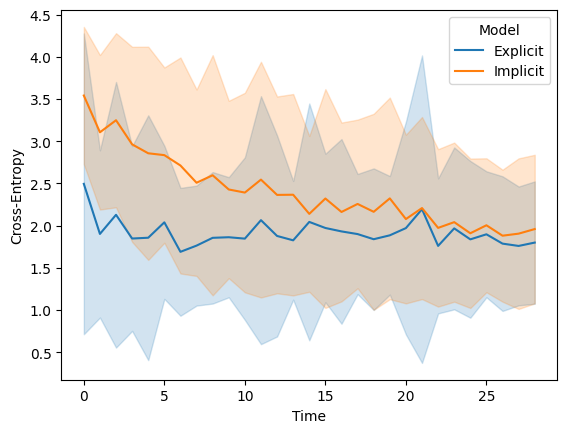

In [ ]:
sns.lineplot(df, x='Time', y='Cross-Entropy', hue='Model', errorbar='sd')

# Posterior predictive : Explicit vs Implicit GRU

In [2]:
task = DSMDiffusion.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/jdj9u44t/last.ckpt", strict=False
)
task.cuda();

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [3]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50
decoder = task.full_data.base_task.model.decoder.lm_head.cuda()
decoder: nn.Linear

In [14]:
N_SEQS = 50
N_SAMPLES = 100
MAX_LEN = 30

dataset = task.full_data
dataset: GRUDiffusionDataset
dataset.cfg.suffix_size = [MAX_LEN, MAX_LEN]

hmms = dataset.base_task.val_latents[torch.randperm(len(dataset.base_task.val_latents))[:N_SEQS]].long().cpu()
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset.__getitems__(hmms).values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [15]:
# Compute the bayesian posterior predictive
oracle_pred = torch.zeros(N_SEQS, MAX_LEN, 50)
for j in range(len(hmms)):
    oracle_pred[j] = torch.Tensor(
        task.full_data.base_task.full_data.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(cond_input_ids)[j]
        )["post_pred"][1:].tolist()
    ).cpu()

# Compute the implicit posterior predictive
implicit_pred = torch.nn.functional.softmax(
    task.full_data.base_task.model(cond_input_ids)[:, :, :50], dim=-1
).cpu().detach()

In [16]:
# Compute the explicit posterior predictive
explicit_pred = torch.zeros(N_SEQS, N_SAMPLES, MAX_LEN, 50)

for batch_ids in torch.split(torch.arange(N_SEQS), 100):

    for i in tqdm(range(1, MAX_LEN + 1)):
        
        # Sample from the variational encoder
        z_t = task.sample(
            len(batch_ids) * N_SAMPLES,
            cond=repeat(cond_tokens[batch_ids,:i], "b l d -> (b n) l d", n=N_SAMPLES) if cond_tokens != None else None,
            cond_input_ids=repeat(cond_input_ids[batch_ids, :i],  "b l -> (b n) l", n=N_SAMPLES) if cond_input_ids != None else None,
            cond_mask=torch.ones(size=(len(batch_ids)*N_SAMPLES, i), dtype=bool).cuda(),
            cls_free_guidance=1.0,
        )
        if task.cfg.normalize_latent:
            z_t = task.unnormalize_latent(z_t)

        # Use the decoder conditionned on the sampled latent (a linear layer)
        explicit_pred_ = decoder(z_t[:, -1])[:, :50]
        # Perform monte-carlo estimate
        explicit_pred_ = rearrange(
            torch.nn.functional.softmax(explicit_pred_, dim=-1),
            "(b n) c -> b n c",
            b=len(batch_ids),
            n=N_SAMPLES,
        )
        explicit_pred[batch_ids, :, torch.full_like(batch_ids, fill_value=i - 1)] = (
            explicit_pred_.cpu()
        )

100%|██████████| 30/30 [25:34<00:00, 51.16s/it]


In [17]:
explicit_pred.detach_()

tensor([[[[2.9501e-10, 9.4375e-03, 7.2593e-02,  ..., 1.6248e-01,
           2.3344e-05, 1.0444e-04],
          [1.2353e-09, 9.6833e-03, 8.8880e-03,  ..., 7.1374e-04,
           6.3740e-02, 4.0627e-05],
          [3.4786e-10, 4.4236e-05, 4.4702e-06,  ..., 5.4873e-04,
           3.9479e-02, 9.1932e-06],
          ...,
          [3.0242e-10, 2.4084e-05, 1.3565e-05,  ..., 1.4682e-04,
           2.1694e-01, 9.9284e-07],
          [8.4453e-10, 1.0220e-04, 2.1905e-03,  ..., 1.4696e-02,
           4.2775e-04, 2.9589e-05],
          [7.4023e-10, 3.3364e-05, 1.9493e-05,  ..., 1.2848e-04,
           4.8896e-02, 6.7256e-07]],

         [[2.5156e-10, 3.5695e-04, 5.6117e-05,  ..., 7.6391e-04,
           2.2646e-05, 7.1575e-06],
          [2.8572e-09, 3.7078e-02, 9.5094e-05,  ..., 4.7188e-04,
           4.3687e-01, 6.8809e-06],
          [1.8458e-10, 2.3844e-05, 7.8665e-06,  ..., 5.1900e-04,
           4.0762e-01, 1.0361e-06],
          ...,
          [2.4810e-10, 2.1629e-05, 4.2425e-05,  ..., 4.5864

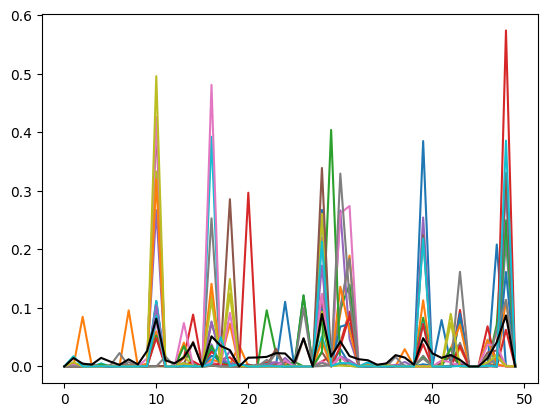

In [ ]:
t = 0
#for i in range(N_SAMPLES):
#    plt.plot(explicit_pred[0,i,t].detach(), label='Explicit')
plt.plot(explicit_pred[0,:,t].mean(0), label='Explicit')
plt.plot(oracle_pred[0,t], color='black', label='Oracle')
#plt.plot(implicit_pred[0,t], color='yellow', label='Implicit')
#plt.legend()

In [18]:
def KLDiv(p,q):
    return torch.sum(p * (p.log() - q.log()), -1)

explicit_kl_b = KLDiv(explicit_pred.mean(1), oracle_pred)
implicit_kl_b = KLDiv(implicit_pred, oracle_pred)
explicit_kl_f = KLDiv(oracle_pred, explicit_pred.mean(1))
implicit_kl_f = KLDiv(oracle_pred, implicit_pred)

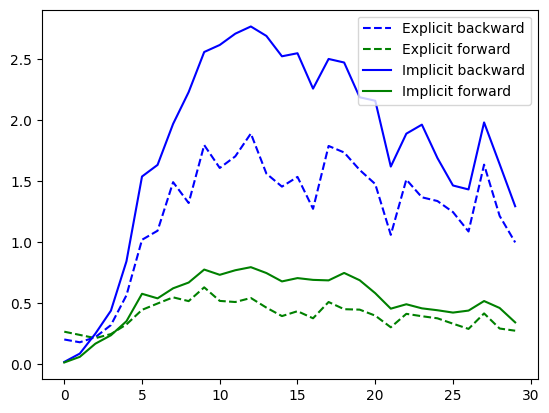

In [20]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.plot(implicit_kl_b.mean(0), label='Implicit backward', color='blue')
plt.plot(implicit_kl_f.mean(0), label='Implicit forward', color='green')
plt.legend()

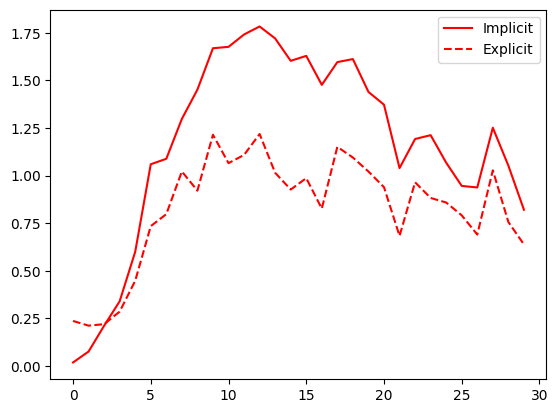

In [22]:
plt.plot((implicit_kl_b.mean(0) + implicit_kl_f.mean(0))/2, label='Implicit', color='red')
plt.plot((explicit_kl_b.mean(0) + explicit_kl_f.mean(0))/2, label='Explicit', color='red', linestyle='--')
plt.legend()

In [75]:
df1 = pd.DataFrame(explicit_kl_b)
df1['Model'] = "Explicit"
df1['Direction'] = "Backward"

df2 = pd.DataFrame(implicit_kl_b)
df2['Model'] = "Implicit"
df2['Direction'] = "Backward"

df3 = pd.DataFrame(explicit_kl_f)
df3['Model'] = "Explicit"
df3['Direction'] = "Forward"

df4 = pd.DataFrame(implicit_kl_f)
df4['Model'] = "Implicit"
df4['Direction'] = "Forward"

df = pd.concat([df1, df2, df3, df4]).melt(id_vars=['Model', 'Direction'], var_name='Time', value_name='Cross-Entropy')
df['Samples'] = N_SAMPLES

In [62]:
df_total = df.copy()

In [76]:
df_total = pd.concat([df_total, df])

<Axes: xlabel='Time', ylabel='Cross-Entropy'>

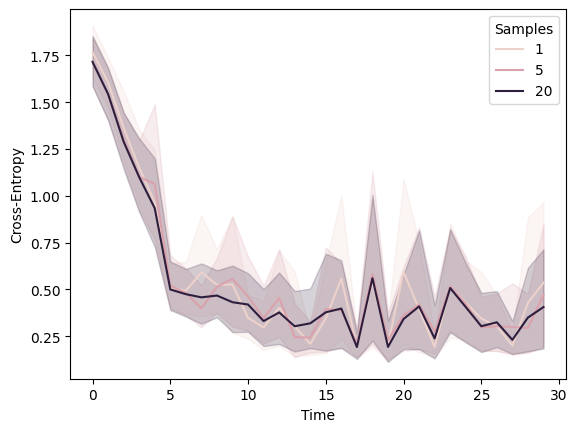

In [99]:
sns.lineplot(df_total[(df_total['Model'] == 'Explicit') & (df_total['Direction'] == 'Backward')], x='Time', y='Cross-Entropy', hue='Samples')

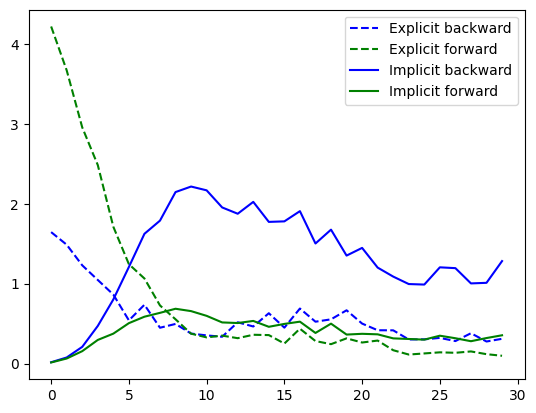

In [49]:
df1 = pd.DataFrame(torch.nn.functional.cross_entropy(
        torch.log(explicit_pred[:, :-1].transpose(1, 2)),
        sequences[:, 1:].cpu().long(),
        reduction="none",
    ))
df1['Model'] = "Explicit"
df2 = pd.DataFrame(torch.nn.functional.cross_entropy(
        torch.log(implicit_pred[:, :-1].transpose(1, 2).cpu().detach()),
        sequences[:, 1:].cpu().long(),
        reduction="none",
    ))
df2['Model'] = "Implicit"
df = pd.concat([df1, df2]).melt(id_vars=['Model'], var_name='Time', value_name='Cross-Entropy')

<Axes: xlabel='Time', ylabel='Cross-Entropy'>

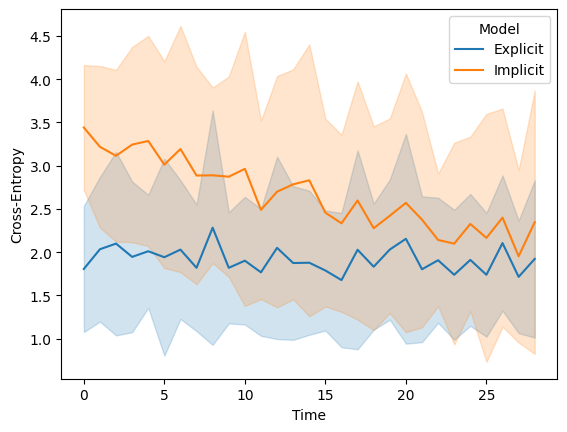

In [50]:
sns.lineplot(df, x='Time', y='Cross-Entropy', hue='Model', errorbar='sd')

# Posterior predictive : Explicit vs Implicit GRU (WITH HIDDEN STATE CONDITIONNING)

In [25]:
task = DSMDiffusion.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/yzk4q7zo/last.ckpt", strict=False
)
task.cuda();

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [26]:
N_SEQS = 50
N_SAMPLES = 20
MAX_LEN = 30

dataset = task.full_data
dataset: GRUDiffusionDataset
dataset.cfg.suffix_size = [MAX_LEN, MAX_LEN]

hmms = dataset.base_task.val_latents[torch.randperm(len(dataset.base_task.val_latents))[:N_SEQS]].long().cpu()
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset.__getitems__(hmms).values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [27]:
# Compute the bayesian posterior predictive
oracle_pred = torch.zeros(N_SEQS, MAX_LEN, 50)
for j in range(len(hmms)):
    oracle_pred[j] = torch.Tensor(
        task.full_data.base_task.full_data.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(cond_input_ids)[j]
        )["post_pred"][1:].tolist()
    ).cpu()

# Compute the implicit posterior predictive
implicit_pred = torch.nn.functional.softmax(
    task.full_data.base_task.model(cond_input_ids)[:, :, :50], dim=-1
).cpu().detach()

In [28]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50
decoder = task.full_data.base_task.model.decoder.lm_head.cuda()
decoder: nn.Linear

In [29]:
from torch.nn import GRU

RNN = task.full_data.base_task.model.decoder.backbone
RNN : GRU

# Compute the explicit posterior predictive
explicit_pred = torch.zeros(N_SEQS, N_SAMPLES, MAX_LEN, 50)

with torch.no_grad():

    for batch_ids in torch.split(torch.arange(N_SEQS), 100):

        state = torch.zeros(
            RNN.num_layers,
            len(batch_ids),
            RNN.hidden_size,
            dtype=torch.float32,
            device="cuda",
        )

        for i in tqdm(range(1, MAX_LEN + 1)):

            _, state = RNN(
                task.full_data.base_task.model.decoder.embedding(cond_input_ids[:,[i-1]]), hx=state
            )

            # Sample from the variational encoder
            z_t = task.sample(
                len(batch_ids) * N_SAMPLES,
                cond=repeat(state.transpose(0,1), "b l d -> (b n) l d", n=N_SAMPLES),
                cond_mask=torch.ones(
                    size=(len(batch_ids) * N_SAMPLES, 6), dtype=bool
                ).cuda(),
                cls_free_guidance=1.0,
            )
            if task.cfg.normalize_latent:
                z_t = task.unnormalize_latent(z_t)

            # Use the decoder conditionned on the sampled latent (a linear layer)
            explicit_pred_ = decoder(z_t[:, -1])[:, :50]
            # Perform monte-carlo estimate
            explicit_pred_ = rearrange(
                torch.nn.functional.softmax(explicit_pred_, dim=-1),
                "(b n) c -> b n c",
                b=len(batch_ids),
                n=N_SAMPLES,
            )
            explicit_pred[batch_ids, :, torch.full_like(batch_ids, fill_value=i - 1)] = (
                explicit_pred_.cpu()
            )
    explicit_pred.detach_();

100%|██████████| 30/30 [03:22<00:00,  6.76s/it]


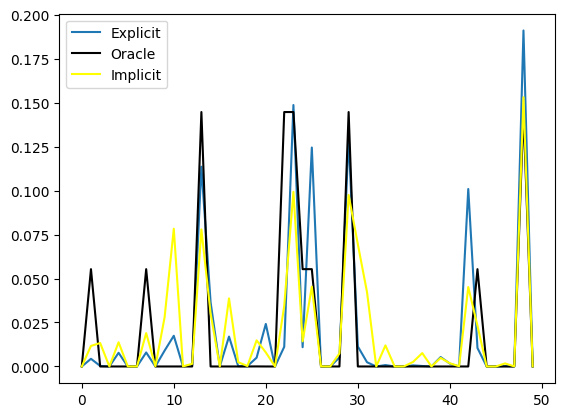

In [22]:
t = 10
#for i in range(5):
#    plt.plot(explicit_pred[1,i,t].detach(), label='Explicit')
plt.plot(explicit_pred[1,:,t].mean(0), label='Explicit')
plt.plot(oracle_pred[1,t], color='black', label='Oracle')
plt.plot(implicit_pred[1,t], color='yellow', label='Implicit')
plt.legend()

In [30]:
def KLDiv(p,q):
    return torch.sum(p * (p.log() - q.log()), -1)

explicit_kl_b = KLDiv(explicit_pred.mean(1), oracle_pred)
implicit_kl_b = KLDiv(implicit_pred, oracle_pred)
explicit_kl_f = KLDiv(oracle_pred, explicit_pred.mean(1))
implicit_kl_f = KLDiv(oracle_pred, implicit_pred)

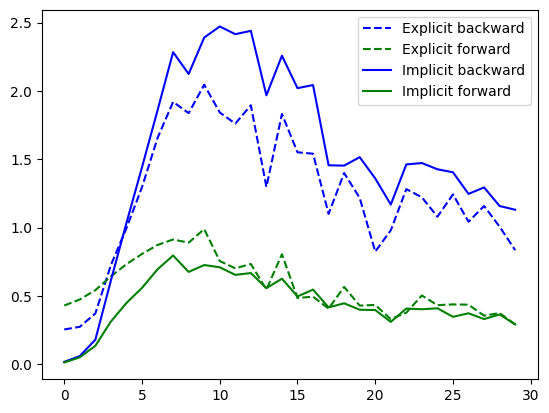

In [31]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.plot(implicit_kl_b.mean(0), label='Implicit backward', color='blue')
plt.plot(implicit_kl_f.mean(0), label='Implicit forward', color='green')
plt.legend()

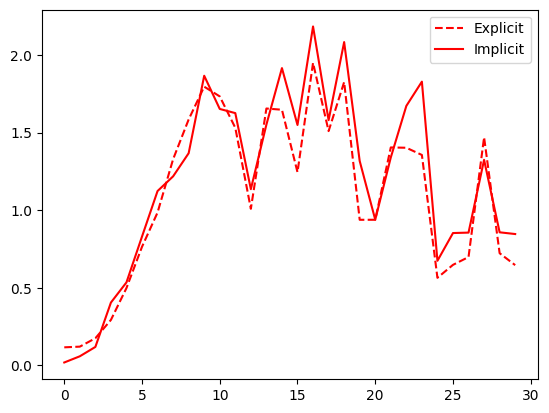

In [ ]:
plt.plot((explicit_kl_b.mean(0) + explicit_kl_f.mean(0))/2, label='Explicit', color='red', linestyle='--')
plt.plot((implicit_kl_b.mean(0) + implicit_kl_f.mean(0))/2, label='Implicit', color='red')
plt.legend()